<a href="https://colab.research.google.com/github/Biruk-gebru/Icog-classes/blob/main/Sparcity_in_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"birukgebru","key":"6dbcc18eb731d235c8b8cd2e793350d6"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d puneet6060/intel-image-classification


Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 99% 344M/346M [00:13<00:00, 27.9MB/s]
100% 346M/346M [00:13<00:00, 26.2MB/s]


In [5]:
!unzip intel-image-classification.zip -d intel-image-classification


Streaming output truncated to the last 5000 lines.
  inflating: intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel-image-classification/seg_train/seg_train/mountain/

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    'intel-image-classification/seg_train/seg_train',
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
)

validation_dataset = image_dataset_from_directory(
    'intel-image-classification/seg_test/seg_test',
    image_size=(150, 150),
    batch_size=32,
    label_mode='int'
)


Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [7]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout layer with 50% rate
    layers.Dense(6, activation='softmax')  # 6 output classes
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [9]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 901s 2s/step - accuracy: 0.5175 - loss: 1.2506 - val_accuracy: 0.7120 - val_loss: 0.7611
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 894s 2s/step - accuracy: 0.7408 - loss: 0.7036 - val_accuracy: 0.7880 - val_loss: 0.5890
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 932s 2s/step - accuracy: 0.8071 - loss: 0.5371 - val_accuracy: 0.8177 - val_loss: 0.5277
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - accuracy: 0.8505 - loss: 0.4238 - val_accuracy: 0.8197 - val_loss: 0.5508
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 919s 2s/step - accuracy: 0.8851 - loss: 0.3322 - val_accuracy: 0.8270 - val_loss: 0.5947
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 917s 2s/step - accuracy: 0.9165 - loss: 0.2452 - val_accuracy: 0.8343 - val_loss: 0.5959
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 918s 2s/step - accuracy: 0.9376 - loss: 0.1790 - val_accuracy: 0.8250 - val_loss: 0.6902
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 881s 2s/step - accuracy: 0.9526 - loss: 0.1388 - val_accu

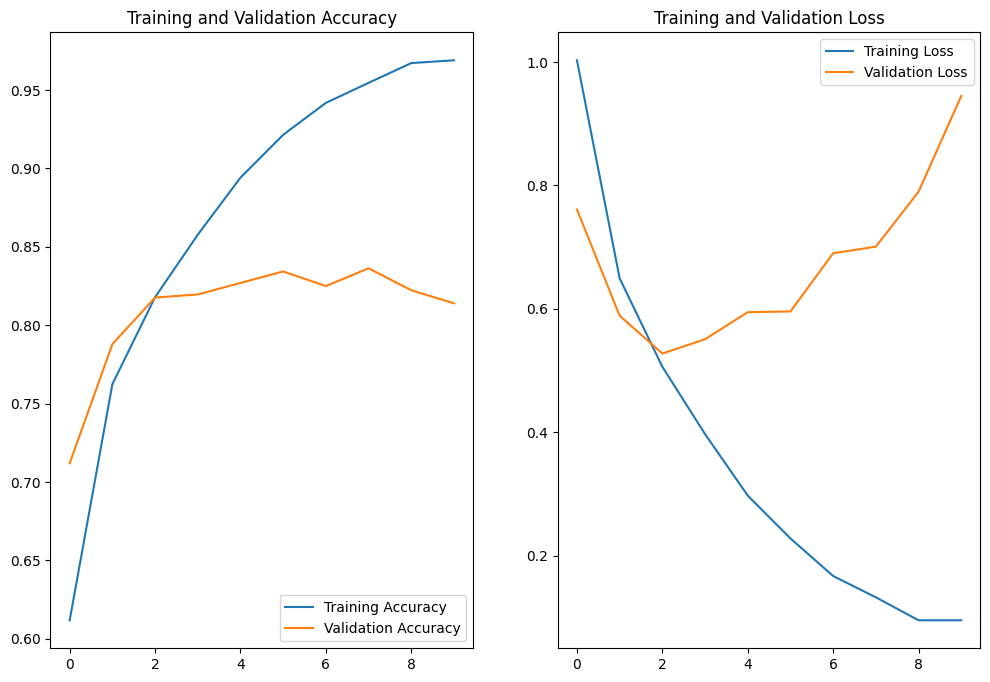

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(10)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [12]:
!pip install scikit-learn
!pip install scikit-learn numpy matplotlib



In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.decomposition import DictionaryLearning
import os

# Load a small subset of images from the dataset for Dictionary Learning
image_folder = 'intel-image-classification/seg_train/seg_train/buildings'  # Change category as needed
image_files = os.listdir(image_folder)[:100]  # Load only 100 images to keep it efficient

image_data = []

for img_file in image_files:
    img_path = os.path.join(image_folder, img_file)
    img = load_img(img_path, target_size=(64, 64), color_mode="grayscale")  # Convert to grayscale
    img_array = img_to_array(img).flatten()  # Flatten into a 1D vector
    image_data.append(img_array)

image_data = np.array(image_data)
print("Image Data Shape:", image_data.shape)  # Should be (100, 4096) for 100 images of size 64x64


Image Data Shape: (100, 4096)


In [18]:
from sklearn.decomposition import MiniBatchDictionaryLearning


# Apply Dictionary Learning
n_components = 100  # Number of dictionary atoms
dict_learner = MiniBatchDictionaryLearning(n_components=n_components, alpha=1)
dictionary = dict_learner.fit(image_data).components_

print("Dictionary Shape:", dictionary.shape)  # Should be (100, 4096)


Dictionary Shape: (100, 4096)


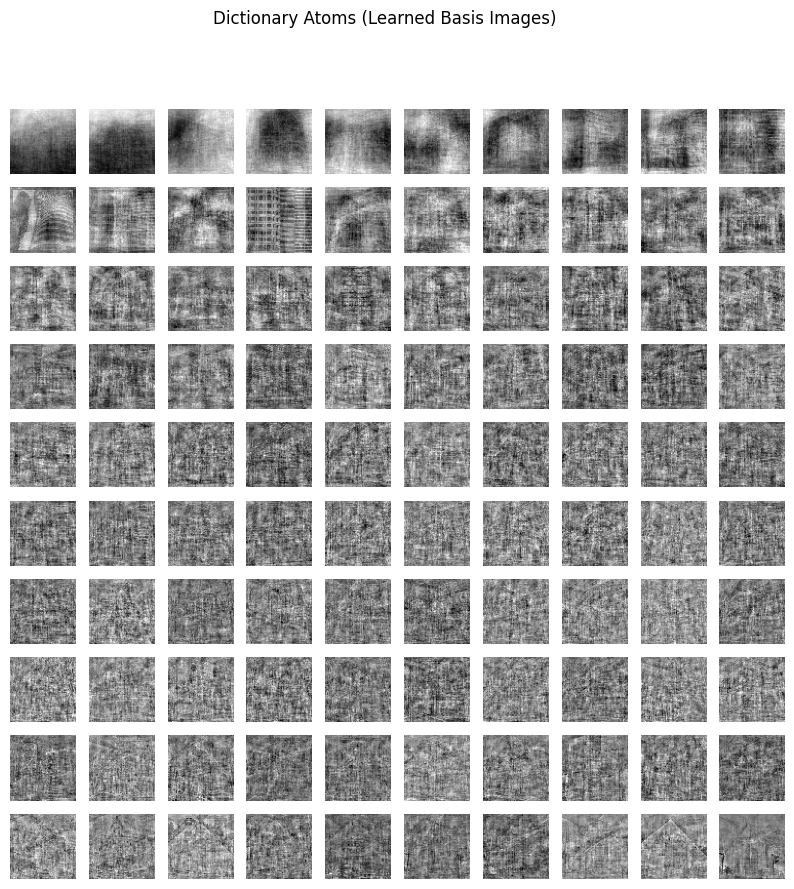

In [19]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    atom = dictionary[i].reshape(64, 64)  # Reshape to original size
    ax.imshow(atom, cmap='gray')
    ax.axis('off')

plt.suptitle("Dictionary Atoms (Learned Basis Images)")
plt.show()


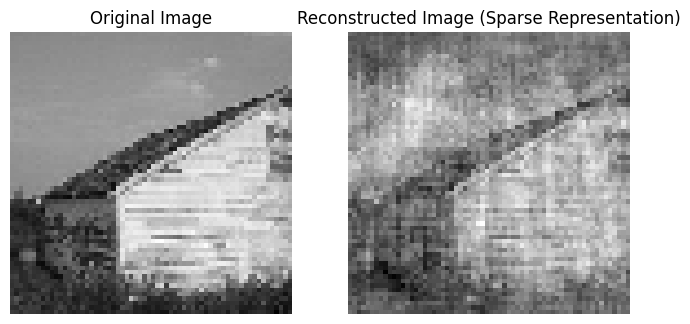

In [20]:
from sklearn.linear_model import OrthogonalMatchingPursuit

# Take a test image
test_img = image_data[0]  # Use the first image
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=10)  # Sparse coding with at most 10 nonzero coefficients
sparse_code = omp.fit(dictionary.T, test_img).coef_

# Reconstruct the image using sparse coefficients
reconstructed_img = np.dot(sparse_code, dictionary).reshape(64, 64)

# Plot original vs reconstructed image
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(test_img.reshape(64, 64), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title("Reconstructed Image (Sparse Representation)")
axes[1].axis('off')

plt.show()
